conda create -n "lec" python=3.7

python -m ipykernel install --user --name lec --display-name lec

conda activate lec

In [4]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install tensorflow

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [3]:
import tensorflow as tf
tf.__version__

'1.7.1'

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [5]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

/Users/jubong/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________
________

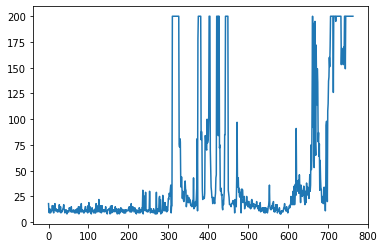

In [6]:
import random
from collections import deque

# 리플레이를 저장할 리스트
REPLAY_MEMORY = deque()
 
env = wrap_env(gym.make("CartPole-v0"))

input_size = 4
output_size = 2

# 학습 매캐변수를 설정한다.
learning_rate = .001
discount_reward = .99
num_episodes = 2000
max_step = 100
max_early_stop_length = 20
epsilon_decay = 0.9
initial_epsilon = .5
min_epsilon = .1
batch_size = 64
replay_counter = 0

# 보상의 총합계를 담을 리스트를 생성한다.
rewardList = []

def update_weights_target_model():
    target_Q_Network_model.set_weights(
        Q_Network_model.get_weights()
    )

def update_from_memory(network, target_network):
    global replay_counter
    observation_batch = np.ndarray(shape=[batch_size, input_size])
    y_batch = np.ndarray(shape=[batch_size, output_size])
  
    minibatch = random.sample(REPLAY_MEMORY, batch_size)
    i = 0
    for sample in minibatch:
        observation, action, reward, next_observation, done = sample # unpacking
        
        # policy prediction for a given state
        Q_values = network.predict(observation)
        if done:
            Q_values[0, action] = reward
        else:
            Q_values_next = target_network.predict(next_observation)
            Q_values[0, action] = reward + discount_reward * np.max(Q_values_next)
        observation_batch[i] = observation
        y_batch[i] = Q_values
        i += 1
    
    # DQN 알고리즘으로 학습
    network.fit(
        x=np.array(observation_batch),
        y=np.array(y_batch),
        batch_size=batch_size,
        epochs=1,
        verbose=0
    )
    if replay_counter % 10 == 0:
        update_weights_target_model()
    replay_counter += 1


# Q-Network 생성
input = tf.keras.Input(shape=[input_size, ], dtype='float32', name='input')
output = tf.keras.layers.Dense(64, kernel_initializer='he_normal')(input)
output = tf.keras.layers.LeakyReLU(alpha=0.05)(output)
output = tf.keras.layers.Dense(64, kernel_initializer='he_normal')(output)
output = tf.keras.layers.LeakyReLU(alpha=0.05)(output)
output = tf.keras.layers.Dense(output_size, activation='linear')(output)

Q_Network_model = tf.keras.Model(input, output)
Q_Network_model.summary()

Q_Network_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate)
)

target_output = tf.keras.layers.Dense(64, kernel_initializer='he_normal')(input)
target_output = tf.keras.layers.LeakyReLU(alpha=0.05)(target_output)
target_output = tf.keras.layers.Dense(64, kernel_initializer='he_normal')(target_output)
target_output = tf.keras.layers.LeakyReLU(alpha=0.05)(target_output)
target_output = tf.keras.layers.Dense(output_size, activation='linear')(target_output)

target_Q_Network_model = tf.keras.Model(input, target_output)
target_Q_Network_model.summary()

target_Q_Network_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate)
)
            
early_stop_length = 0
stopped_episode_num = 0

for current_episode_num in range(num_episodes):
    # 환경을 리셋하고 첫 번째 새로운 관찰(observation)을 얻는다.
    observation = env.reset()
    rewardAll = 0
    done = False
    step = 0
    epsilon = initial_epsilon
  
    print(current_episode_num, end=', ')
    # Q 테이블 학습 알고리즘
    while not done:
        # Q 테이블로부터 (노이즈와 함께) 그리디하게 액션을 선택
        observation = np.reshape(observation, (1, input_size))
        Q_values = Q_Network_model.predict(observation)
        if epsilon > min_epsilon:
            epsilon *= epsilon_decay  
        if np.random.rand(1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_values)
      
        # 환경으로부터 새로운 상태와 보상을 얻는다.
        next_observation, reward, done, information = env.step(action)
        next_observation = np.reshape(next_observation, (1, input_size))

        # state, action, reward, next_state, done 을 메모리에 저장
        REPLAY_MEMORY.append((observation, action, reward, next_observation, done))

        # 메모리에 10000개 이상의 값이 들어가면 가장 먼저 들어간 것부터 삭제
        if len(REPLAY_MEMORY) > 2000:
            REPLAY_MEMORY.popleft()

        rewardAll += reward
        observation = next_observation
        step += 1
  
    # update model
    if len(REPLAY_MEMORY) > batch_size:
#         for _ in range(10):
        update_from_memory(Q_Network_model, target_Q_Network_model)
                       
    early_stop_length += 1
    if rewardAll <= 195.:
        early_stop_length = 0
    if early_stop_length >= max_early_stop_length:
        break
    rewardList.append(rewardAll)
    stopped_episode_num = current_episode_num

print("Score over time: " + str(sum(rewardList) / num_episodes))
print("Stopped episode num: " + str(current_episode_num))

plt.plot(rewardList)
plt.show()

In [7]:
import os
import glob

mp4list = glob.glob('video/*.mp4')
for f in mp4list:
    os.remove(f)

env = wrap_env(gym.make("CartPole-v0"))

observation = env.reset()
t = 0

while True:
    env.render()
    observation = np.reshape(observation, (1, input_size))
    #your agent goes here
    action = np.argmax(Q_Network_model.predict(observation))
         
    observation, reward, done, info = env.step(action)
    t += 1
    if done:
        print(t)
        observation = env.reset()
    if t >= 1000:
        break

env.close()
show_video()

/Users/jubong/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


200
400
600
800
1000


In [9]:
import gym
env = gym.make('CartPole-v0')
env.reset()
while True:
    env.render()
    observation = np.reshape(observation, (1, input_size))
    #your agent goes here
    action = np.argmax(Q_Network_model.predict(observation))
         
    observation, reward, done, info = env.step(action)
    if done:
        break
env.close()

/Users/jubong/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
